In [3]:
import lightgbm as lgb
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin


In [2]:
!pip install hyperopt

In [ ]:
from sklearn.metrics import auc
from collections import Counter
def calculate_mAP(preds,label):
    ## mAP calculation
    AP = []
    num_class = 10
    predict_label_count_dict = Counter(preds)
    predict_label_count_dict = dict(sorted(predict_label_count_dict.items()))

    # For each class
    for c, freq in predict_label_count_dict.items() :
        TP = 0
        FN = 0

        temp_precision = []
        temp_recall = []

        for i in range(len(preds)):
            # Calculate TP and FN
            if label[i] == c and preds[i] == c :
                TP += 1

            elif label[i] != c and preds[i] == c :
                FN += 1

            # Calculate precision and recall
            if TP+FN != 0:
                temp_precision.append(TP/(TP+FN))
                temp_recall.append(TP/freq)

        # Save the AP value of each class to AP array
        AP.append(auc(temp_recall, temp_precision))

    # Calculate mAP
    mAP = sum(AP) / num_class

    return mAP

##pipeline

In [1]:

from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import pandas as pd

train = pd.read_csv('all_augmented.csv')
test = pd.read_csv('public_test_data.csv')
train.isnull().any().sum()
test.isnull().any().sum()
df_train = train.copy()
df_test = test.copy()
X_train= df_train.drop(['label'],axis = 1)
X_label = df_train['label']
y_test = df_test.drop(['label'],axis = 1)
y_label = df_test['label']

X_train = X_train.astype('float32')
y_test = y_test.astype('float32')
X_train /= 255.0
y_test /=255.0
with open('./label.txt', 'r') as file:
    lines = file.readlines()

series_data = pd.Series([int(line.strip().split()[1]) if line.strip().split()[1].isdigit() else 0 for line in lines], name='label', dtype='int64')
y_label = series_data

# # seed = 99
# # np.random.seed(seed)
# # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = seed)
# print("PCA")
# # pca = PCA(n_components=400, whiten=True)
# pca = PCA(n_components=400)
# # PCA 객체 학습
# pca.fit(X_train)

In [2]:
X_train.shape

(93000, 784)

In [ ]:

X_test.shape

In [ ]:
!pip install optuna

In [ ]:
y_train = y_train.values # change to array for mAP
y_test = y_test.values # change to array for mAP

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import optuna

def objective(trial):
    # Define hyperparameters
    params = {
        'lgbm__objective': 'multiclass',
        'lgbm__metric': 'multi_logloss',
        'lgbm__num_class': 10,
        'lgbm__verbosity': -1,
        'lgbm__boosting_type': 'gbdt',
        'lgbm__lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lgbm__lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'lgbm__num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'lgbm__feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'lgbm__bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'lgbm__bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lgbm__min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lgbm__learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'lgbm__max_depth': trial.suggest_int('max_depth', 1, 10),
        'lgbm__min_gain_to_split': trial.suggest_loguniform('min_gain_to_split', 0.1, 1),
        'lgbm__max_bin': trial.suggest_int('max_bin', 128, 512),
        'lgbm__scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 100.0),
        'lgbm__random_state':42,

    }

    # Define PCA and LGBM model
    pca = PCA(n_components=400)
    lgbm = lgb.LGBMClassifier()

    # Define pipeline
    lgbm_pipe = Pipeline([
        ('pca', pca),
        ('lgbm', lgbm)
    ], verbose=True)

    # Set parameters
    lgbm_pipe.set_params(**params)

    # Splitting the data
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, X_label, test_size=0.25, stratify=X_label)

    # Train model
    lgbm_pipe.fit(train_x, train_y)

    # Predict on validation set
    preds = lgbm_pipe.predict(valid_x)

    # Calculate mAP
    mAP = calculate_mAP(preds, valid_y)

    return mAP


# Create study object
study = optuna.create_study(direction='maximize')

# Start optimization
study.optimize(objective, n_trials=100)

# Print best parameters
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))


In [ ]:
# 최적의 하이퍼파라미터 출력
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [ ]:

optuna.visualization.plot_optimization_history(study)

In [ ]:

# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
##Hyperopt

In [17]:
from sklearn.metrics import auc
from collections import Counter
def calculate_mAP(preds,label):
    ## mAP calculation
    AP = []
    num_class = 10
    predict_label_count_dict = Counter(preds)
    predict_label_count_dict = dict(sorted(predict_label_count_dict.items()))

    # For each class
    for c, freq in predict_label_count_dict.items() :
        TP = 0
        FN = 0

        temp_precision = []
        temp_recall = []

        for i in range(len(preds)):
            # Calculate TP and FN
            if label[i] == c and preds[i] == c :
                TP += 1

            elif label[i] != c and preds[i] == c :
                FN += 1

            # Calculate precision and recall
            if TP+FN != 0:
                temp_precision.append(TP/(TP+FN))
                temp_recall.append(TP/freq)

        # Save the AP value of each class to AP array
        AP.append(auc(temp_recall, temp_precision))

    # Calculate mAP
    mAP = sum(AP) / num_class

    return mAP

In [18]:
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

In [19]:
!pip install hyperopt

In [20]:
# 데이터 로드
train = pd.read_csv('all_augmented.csv')
test = pd.read_csv('public_test_data.csv')

In [21]:
print(train.shape)
print(test.shape)

(93000, 785)
(10000, 785)


In [22]:
df_train = train.copy()
df_test = test.copy()

In [23]:
X_train= df_train.drop(['label'],axis = 1)
X_label = df_train['label']
y_test = df_test.drop(['label'],axis = 1)
y_label = df_test['label']

X_train = X_train.astype('float32')
y_test = y_test.astype('float32')
X_train /= 255.0
y_test /=255.0

In [24]:
"""
public_test_label.txt -> y_label
필요한 경우에 실행
"""

with open('./label.txt', 'r') as file:
    lines = file.readlines()

series_data = pd.Series([int(line.strip().split()[1]) if line.strip().split()[1].isdigit() else 0 for line in lines], name='label', dtype='int64')
y_label = series_data

In [25]:
X_label = X_label.values # change to array for mAP
y_label = y_label.values # change to array for mAP

In [26]:


# 최적화할 파라미터 공간 정의
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.choice('max_depth', range(1, 11)),
    'num_leaves': hp.choice('num_leaves', range(2, 256)),
    'feature_fraction': hp.uniform('feature_fraction', 0.4, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, 1.0),
    'bagging_freq': hp.choice('bagging_freq', range(1, 8)),
    'min_child_samples': hp.choice('min_child_samples', range(5, 101)),
    'lambda_l1': hp.loguniform('lambda_l1', 1e-8, 10.0),
    'lambda_l2': hp.loguniform('lambda_l2', 1e-8, 10.0),
    'min_gain_to_split': hp.loguniform('min_gain_to_split', 0.1, 1),
    'max_bin': hp.choice('max_bin', range(128, 513)),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1.0, 100.0),
}

# 최적화할 목표 함수 정의
def objective(space):
    model = lgb.LGBMClassifier(
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        num_leaves=int(space['num_leaves']),
        feature_fraction=space['feature_fraction'],
        bagging_fraction=space['bagging_fraction'],
        bagging_freq=int(space['bagging_freq']),
        min_child_samples=int(space['min_child_samples']),
        lambda_l1=space['lambda_l1'],
        lambda_l2=space['lambda_l2'],
        min_gain_to_split=space['min_gain_to_split'],
        max_bin=int(space['max_bin']),
        scale_pos_weight=space['scale_pos_weight'],
        objective='multiclass',
        num_class=10,
        random_state=42,
        verbosity=-1,
        metric='multi_logloss'
    )
    
    pca = PCA(n_components=400)
    lgbm_pipe = Pipeline([
        ('pca', pca),
        ('lgbm', model)
    ])
    
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, X_label, test_size=0.3, stratify=X_label)
    
    lgbm_pipe.fit(train_x, train_y)
    
    preds = lgbm_pipe.predict(valid_x)

    mAP = calculate_mAP(preds, valid_y)
    
    return {'loss': -mAP, 'status': STATUS_OK }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

best_params = space_eval(space, best)

print('Best trial: score {}, params {}'.format(-trials.best_trial['result']['loss'], best_params))


100%|█████████████████████████████████████████████| 100/100 [54:53<00:00, 32.94s/trial, best loss: -0.8109924815774103]
Best trial: score 0.8109924815774103, params {'bagging_fraction': 0.9741159800646928, 'bagging_freq': 4, 'feature_fraction': 0.8421173000020573, 'lambda_l1': 1.5508319044973213, 'lambda_l2': 15.057204729318588, 'learning_rate': 0.14152218783304468, 'max_bin': 484, 'max_depth': 10, 'min_child_samples': 22, 'min_gain_to_split': 1.1054509158164454, 'num_leaves': 136, 'scale_pos_weight': 8.505168405699573}


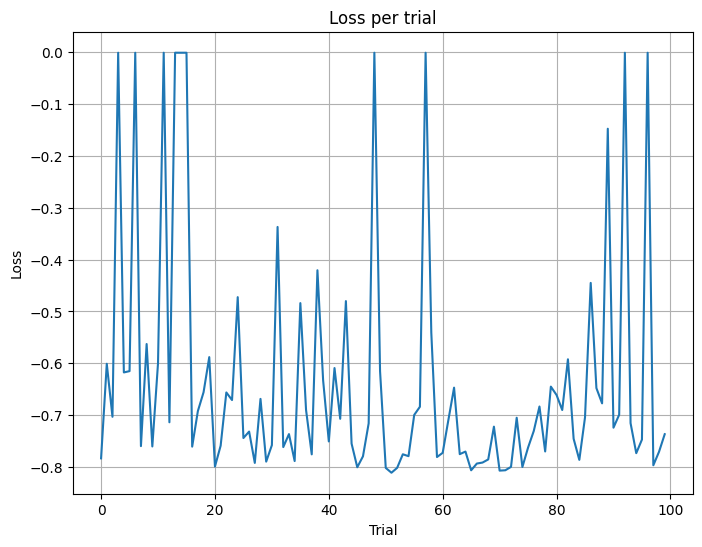

In [27]:
import matplotlib.pyplot as plt

# 손실 함수 값 추출
losses = [x['result']['loss'] for x in trials.trials]

# 손실 함수 값 그래프 그리기
plt.figure(figsize=(8,6))
plt.plot(losses)
plt.title('Loss per trial')
plt.xlabel('Trial')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [28]:
pca = PCA(n_components=400)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(y_test)

X_train_PCA1 = pd.DataFrame(X_train_pca)
X_test_PCA1 = pd.DataFrame(X_test_pca)

In [29]:
clf = lgb.LGBMClassifier(**best_params)
clf.fit(X_train_pca, X_label)

[LightGBM] [Warning] feature_fraction is set=0.8421173000020573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8421173000020573
[LightGBM] [Warning] min_gain_to_split is set=1.1054509158164454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1054509158164454
[LightGBM] [Warning] lambda_l1 is set=1.5508319044973213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5508319044973213
[LightGBM] [Warning] lambda_l2 is set=15.057204729318588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.057204729318588
[LightGBM] [Warning] bagging_fraction is set=0.9741159800646928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9741159800646928
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8421173000020573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8421173000020573
[LightGBM] [Warn

LGBMClassifier(bagging_fraction=0.9741159800646928, bagging_freq=4,
               feature_fraction=0.8421173000020573,
               lambda_l1=1.5508319044973213, lambda_l2=15.057204729318588,
               learning_rate=0.14152218783304468, max_bin=484, max_depth=10,
               min_child_samples=22, min_gain_to_split=1.1054509158164454,
               num_leaves=136, scale_pos_weight=8.505168405699573)

In [30]:
clf_model_train = clf.predict(X_train_PCA1)
clf_model_pred = clf.predict(X_test_PCA1 )

[LightGBM] [Warning] feature_fraction is set=0.8421173000020573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8421173000020573
[LightGBM] [Warning] min_gain_to_split is set=1.1054509158164454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1054509158164454
[LightGBM] [Warning] lambda_l1 is set=1.5508319044973213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5508319044973213
[LightGBM] [Warning] lambda_l2 is set=15.057204729318588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.057204729318588
[LightGBM] [Warning] bagging_fraction is set=0.9741159800646928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9741159800646928
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8421173000020573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8421173000020573
[LightGBM] [Warn

In [31]:
from sklearn.metrics import classification_report
clf_train_score = accuracy_score(X_label, clf_model_train)
clf_pred_score = accuracy_score(y_label, clf_model_pred)

print("----LGBM----")
print("Train Accuracy score: {}".format(clf_train_score))
print("Test Accuracy score: {}".format(clf_pred_score))
print(classification_report(y_label, clf_model_pred))

----LGBM----
Train Accuracy score: 0.9938709677419355
Test Accuracy score: 0.8813
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1000
           1       0.98      0.97      0.97      1000
           2       0.82      0.80      0.81      1000
           3       0.89      0.92      0.90      1000
           4       0.82      0.85      0.83      1000
           5       0.96      0.93      0.95      1000
           6       0.71      0.67      0.69      1000
           7       0.92      0.93      0.92      1000
           8       0.96      0.96      0.96      1000
           9       0.93      0.96      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [32]:
# lgbm_model_train = lgbm_model.flatten()
# lgbm_model_pred = lgbm_model.flatten()
map_train = calculate_mAP(clf_model_train,X_label)
map_test = calculate_mAP(clf_model_pred,y_label)
print("Train Map score: {}".format(map_train))
print("Test Map score: {}".format(map_test))

Train Map score: 0.987618763265585
Test Map score: 0.7813208618484572
